In [ ]:
######## INSTALATION
!pip install sentinelhub
!pip install s2cloudless
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from google.colab import files
from PIL import Image
import datetime as dt
from sentinelhub import SHConfig, BBox, CRS, SentinelHubRequest, DataCollection, \
    MimeType, bbox_to_dimensions
from s2cloudless import S2PixelCloudDetector, CloudMaskRequest, get_s2_evalscript

In [ ]:
"""
Plotting utilities for example notebooks
"""
import matplotlib.pyplot as plt
import numpy as np


def plot_image(image=None, mask=None, ax=None, factor=3.5/255, clip_range=(0, 1), **kwargs):
    """ Utility function for plotting RGB images and masks.
    """
    if ax is None:
        _, ax = plt.subplots(nrows=1, ncols=1)

    mask_color = [255, 255, 255, 255] if image is None else [255, 255, 0, 100]

    if image is None:
        if mask is None:
            raise ValueError('image or mask should be given')
        image = np.zeros(mask.shape + (3,), dtype=np.uint8)

    ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    plt.title("Milanov Vrh 2015 - True Colour",fontsize=12)
    plt.xticks([])
    plt.yticks([])
    plt.savefig("milanov_vrh_barvna.png", bbox_inches='tight', dpi=100)

    if mask is not None:
        cloud_image = np.zeros((mask.shape[0], mask.shape[1], 4), dtype=np.uint8)

        cloud_image[mask == 1] = np.asarray(mask_color, dtype=np.uint8)

        ax.imshow(cloud_image)


def plot_probabilities(image, proba, factor=3.5/255):
    """ Utility function for plotting a RGB image and its cloud probability map next to each other.
    """
    plt.figure(figsize=(15, 15))
    ax = plt.subplot(1, 2, 1)
    ax.imshow(np.clip(image * factor, 0, 1))
    ax = plt.subplot(1, 2, 2)
    ax.imshow(proba, cmap=plt.cm.inferno)

def plot_ndvi(ndvi_image):
    plt.figure(figsize=(15, 15))
    sns.diverging_palette(60, 160, as_cmap=True)
    ax = sns.heatmap(ndvi_image)

    plt.title("Normalised Vegetation Index",fontsize=12)

    plt.savefig("NDVI_1.png", bbox_inches='tight', dpi=100)

    plt.show()

In [ ]:
# setting configuration information to access data from the ScienceHub
def is_config():
  config = SHConfig()

  config.instance_id = 'c7b45463-8ad6-483e-b775-b1a561cca401'
  config.sh_client_id = '766f8ea6-160f-4351-ad48-06058abbd590'
  config.sh_client_secret = 'z^{3w^zz%lrq^;rf-7T:Anu!@[8pJ]_O<*2-NRn9'

  config.save()

  # In case you put the credentials into the configuration file you can leave this unchanged
  CLIENT_ID = ''
  CLIENT_SECRET = ''

  config = SHConfig()

  if CLIENT_ID and CLIENT_SECRET:
      config.sh_client_id = CLIENT_ID
      config.sh_client_secret = CLIENT_SECRET
  return config

In [ ]:
# coordinates of the region
# bbox = BBox([14.569134840593051,45.59918397980536,14.590077528581332,45.612334146131815], crs=CRS.WGS84)

In [ ]:
def get_RGB_bands_data(date:str,bbox:BBox,config): 
  evalscript_true_color = """
      //VERSION=3

      function setup() {
          return {
              input: [{
                  bands: ["B02", "B03", "B04"]
              }],
              output: {
                  bands: 3
              }
          };
      }

      function evaluatePixel(sample) {
          return [sample.B04, sample.B03, sample.B02];
      }
  """

  request = SentinelHubRequest(
      evalscript=evalscript_true_color,
      input_data=[
          SentinelHubRequest.input_data(
              data_collection=DataCollection.SENTINEL2_L1C,
              time_interval=date
          )
      ],
      responses=[
          SentinelHubRequest.output_response('default', MimeType.PNG)
      ],
      bbox=bbox,
      size=bbox_to_dimensions(bbox, 10),
      config=config
  )

  true_color_image = request.get_data()[0]

  true_color_image.shape
  return true_color_image

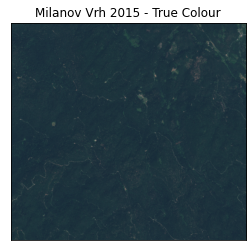

In [ ]:
date = '2015-07-11'
bbox = BBox([14.508835029490873,45.56406848043405,
14.595695686229154,45.62112595663112
], crs=CRS.WGS84)
config = is_config()
true_color_image = get_RGB_bands_data(date,bbox,config)
plot_image(true_color_image)

In [ ]:
def get_all_bands_data(date:str,bbox:BBox,config):  
  evalscript_all_bands = """
      //VERSION=3
      function setup() {
          return {
              input: [{
                  bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"],
                  units: "DN"
              }],
              output: {
                  bands: 13,
                  sampleType: "INT16"
              }
          };
      }

      function evaluatePixel(sample) {
          return [sample.B01,
                  sample.B02,
                  sample.B03,
                  sample.B04,
                  sample.B05,
                  sample.B06,
                  sample.B07,
                  sample.B08,
                  sample.B8A,
                  sample.B09,
                  sample.B10,
                  sample.B11,
                  sample.B12];
      }
  """

  request_all_bands = SentinelHubRequest(
      evalscript=evalscript_all_bands,
      input_data=[
          SentinelHubRequest.input_data(
              data_collection=DataCollection.SENTINEL2_L1C,
              time_interval=date,
              mosaicking_order="leastCC",
          )
      ],
      responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
      bbox=bbox,
      size=bbox_to_dimensions(bbox, 10),
      config=config,
  )

  all_bands_response = request_all_bands.get_data()
  plot_image(all_bands_response[0][:, :, 1:4], factor=3.5 / 1e4, vmax=1)

  return request_all_bands

  request_all_bands = get_all_bands_data('2017-08-24',bbox)
  # plot_image(all_bands_response[0][:, :, 1:4], factor=3.5 / 1e4, vmax=1)

In [ ]:
def get_cloud_classifier(arr_result):
  cloud_detector = S2PixelCloudDetector(
    threshold=0.2,
    average_over=4,
    dilation_size=2,
    all_bands=False
  )
  cloud_prob = cloud_detector.get_cloud_probability_maps(bands)
  cloud_mask = cloud_detector.get_cloud_masks(bands)

  plot_image(mask=cloud_mask)
  plot_image(image=true_color_image, mask=cloud_mask)

  cloud_prob_X = np.copy(cloud_prob)

  cloud_prob_X[cloud_prob_X >= 0.2] = 1
  cloud_prob_X[cloud_prob_X < 0.2] = 0

  arr_result_cloudless = np.copy(arr_result)
  for i in range(arr_result_cloudless.shape[0]):
    for j in range(arr_result_cloudless.shape[1]):
      if cloud_prob_X[i][j] == 1:
        arr_result_cloudless[i][j] = 0

  return arr_result_cloudless

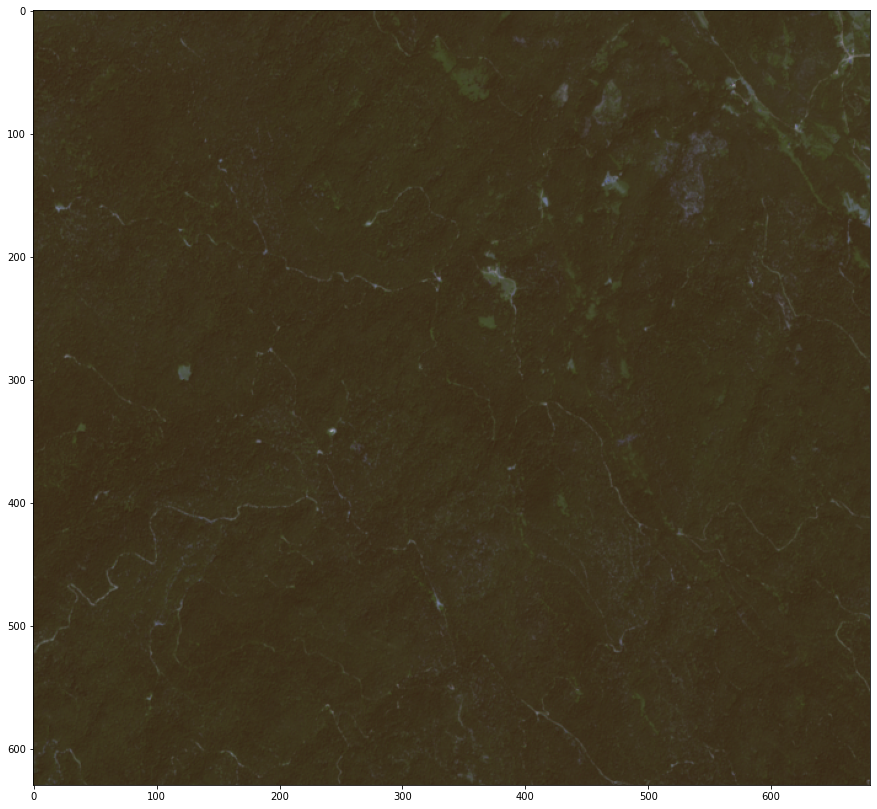

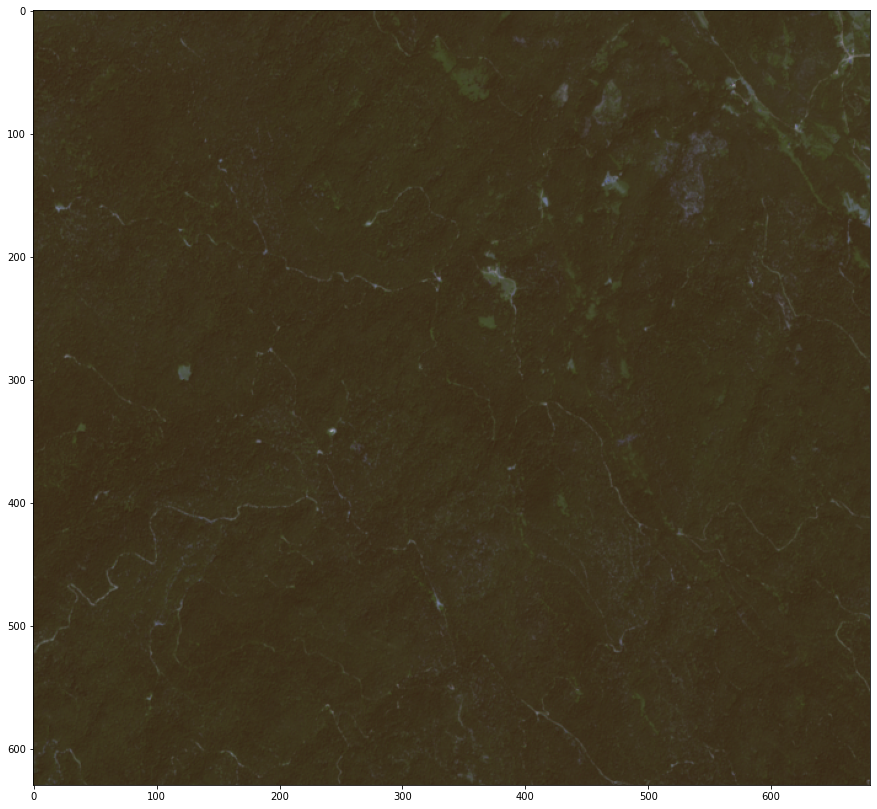

In [ ]:
date = '2015-07-11'
bbox = BBox([14.508835029490873,45.56406848043405,
14.595695686229154,45.62112595663112
], crs=CRS.WGS84)

request_all_bands = get_all_bands_data(date,bbox,config)
all_bands_response = request_all_bands.get_data()
plot_image(all_bands_response[0][:, :, 1:4], factor=3.5 / 1e4, vmax=1)

In [ ]:
def get_band_b8(request_all_bands):
  return request_all_bands.get_data()[0][:,:,7]

def get_band_b4(request_all_bands):
  return request_all_bands.get_data()[0][:,:,3]

def get_band_b3(request_all_bands):
  return request_all_bands.get_data()[0][:,:,2]

def get_band_b11(request_all_bands):
  return request_all_bands.get_data()[0][:,:,10]

band_b11 = get_band_b11(request_all_bands)
band_b8 = get_band_b8(request_all_bands)
band_b4 = get_band_b4(request_all_bands)
band_b3 = get_band_b3(request_all_bands)
print(band_b11)
print(band_b8)
print(band_b4)
print(band_b3)


#        B8 - B4
# NDVI = -------
#        B8 + B4
def get_ndvi(band_b8,band_b4):
  print("NORMALISED VEGETATION INDEX")
  numerator_ndvi = np.subtract(band_b8,band_b4)
  denominator_ndvi = np.add(band_b8,band_b4)
  ndvi_result = np.divide(numerator_ndvi,denominator_ndvi)
  with np.printoptions(threshold=np.inf):
    print('Band 8')
    print("Maximum value: {}".format(np.amax(band_b8)))
    print("Minimum value: {}".format(np.amin(band_b8)))
    print('Band 4')
    print("Maximum value: {}".format(np.amax(band_b4)))
    print("Minimum value: {}".format(np.amin(band_b4)))
    print('Numerator')
    print("Maximum value: {}".format(np.amax(numerator_ndvi)))
    print("Minimum value: {}".format(np.amin(numerator_ndvi)))
    print('Deominator')
    print("Maximum value: {}".format(np.amax(denominator_ndvi)))
    print("Minimum value: {}".format(np.amin(denominator_ndvi)))
    print('NDVI')
    print("Maximum value: {}".format(np.amax(ndvi_result)))
    print("Minimum value: {}".format(np.amin(ndvi_result)))
  return ndvi_result

ndvi_result = get_ndvi(band_b8,band_b4)


#        B4
#  RGI = --
#        B3
def get_rgi(band_b4,band_b3):
  print('REG GREEN INDEEX')
  rgi_result = np.divide(band_b4,band_b3)
  with np.printoptions(threshold=np.inf):
      print(rgi_result.shape)
      print("Maximum value: {}".format(np.amax(rgi_result)))
      print("Minimum value: {}".format(np.amin(rgi_result)))
  return rgi_result
rgi_result = get_rgi(band_b4,band_b3)


#        B11 - B8
# NBUI = --------
#        B11 + B8
def get_nbui(band_b11,band_b8):
  print('NORMALISED BUILD UP INDEX')
  numerator_nbui = band_b11 - band_b8
  denominator_nbui = band_b11 + band_b8
  nbui_result = np.divide(numerator_nbui,denominator_nbui)
  return nbui_result
nbui_result = get_nbui(band_b11,band_b8)

[[ 9  9  9 ... 10 10 10]
 [ 9  9  9 ... 10 10 10]
 [ 9  9  9 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ...  9  9  9]]
[[2908 3131 3447 ... 3254 3193 3186]
 [2797 3173 3341 ... 3257 3190 3247]
 [3167 3238 3221 ... 3523 3302 3559]
 ...
 [2291 2344 2653 ... 2445 2136 2301]
 [2713 2696 2632 ... 2278 2446 2460]
 [2162 2233 2777 ... 2203 2223 2107]]
[[419 355 357 ... 757 762 827]
 [346 371 395 ... 772 834 769]
 [357 348 412 ... 648 669 605]
 ...
 [324 332 319 ... 647 896 469]
 [343 353 343 ... 457 827 527]
 [347 344 328 ... 343 672 450]]
[[700 645 653 ... 939 937 958]
 [618 636 655 ... 942 969 948]
 [617 610 643 ... 874 898 873]
 ...
 [557 596 558 ... 778 928 719]
 [585 629 582 ... 648 981 662]
 [559 585 577 ... 581 768 708]]
NORMALISED VEGETATION INDEX
Band 8
Maximum value: 5293
Minimum value: 920
Band 4
Maximum value: 2053
Minimum value: 227
Numerator
Maximum value: 4877
Minimum value: 515
Deominator
Maximum value: 5709
Minimum value: 1207
NDVI
Maximum

# Normalised Difference Vegetation Index

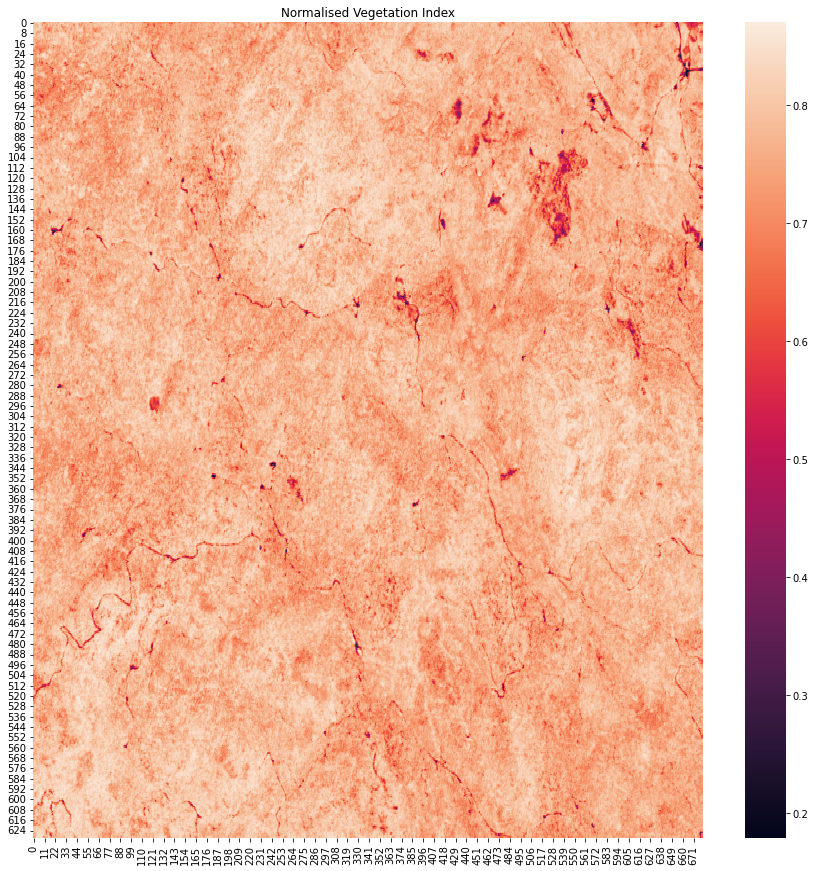

[[0.74812143 0.79632817 0.81230284 ... 0.62253802 0.61466498 0.58783952]
 [0.77982819 0.79063205 0.7885439  ... 0.61677836 0.58548708 0.61703187]
 [0.79738933 0.80591188 0.7731902  ... 0.68928315 0.66305716 0.70941402]
 ...
 [0.75219885 0.75186846 0.78532974 ... 0.58150065 0.40897098 0.66137184]
 [0.77552356 0.76844867 0.76941176 ... 0.66581353 0.49465322 0.6471376 ]
 [0.72339578 0.73302289 0.78872786 ... 0.73055774 0.5357513  0.64802503]]
<class 'numpy.ndarray'>


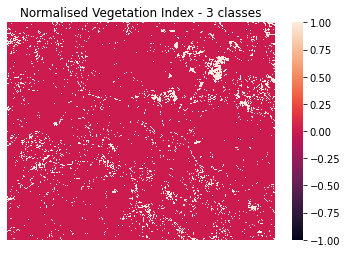

In [ ]:
# NDVI - Classification

plot_ndvi(ndvi_result)
print(ndvi_result)
print(type(ndvi_result))

def ndvi_classification(ndvi_result):
  """
    Seperating the data intoo three groups: 
          1) < 0.2            => bare soil and man-made construction
          2) 0.2 <= x < 0.7   => sparse and unhealthy vegetation
          3) 0.7 <= x         => healthy vegetation
  """
  np_arr_ndvi_X = np.copy(ndvi_result)

  np_arr_ndvi_X[np_arr_ndvi_X < 0.2] = -1
  np_arr_ndvi_X[np_arr_ndvi_X > 0.7] = 0
  np_arr_ndvi_X[np_arr_ndvi_X > 0] = 1

  # show image:
  sns.diverging_palette(60, 160, as_cmap=True)
  ax = sns.heatmap(np_arr_ndvi_X)
  plt.title("Normalised Vegetation Index - 3 classes",fontsize=12)
  plt.xticks([])
  plt.yticks([])
  plt.savefig("NDVI_2.png", bbox_inches='tight', dpi=100)
  # files.download("NDVI_2.png")
  plt.show()
  return np_arr_ndvi_X

np_arr_ndvi_X = ndvi_classification(ndvi_result)

# Red Green Index

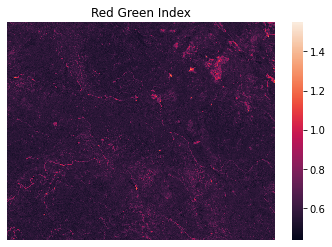

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


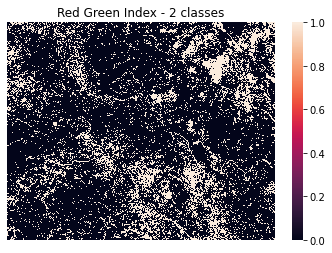

In [ ]:
def rgi_classification(rgi_result):

  # Visualising RGI
  sns.diverging_palette(60, 160, as_cmap=True)
  ax = sns.heatmap(rgi_result)
  plt.title("Red Green Index",fontsize=12)
  plt.xticks([])
  plt.yticks([])
  plt.savefig("RGI_2.png", bbox_inches='tight', dpi=100)
  # files.download("RGI_2.png")
  plt.show()

  """
    Seperating the data intoo three groups: 
          1) < 0.3      => unhealthy
          2) 0.7 <=     => healthy
  """
  np_arr_rgi_X = np.copy(rgi_result)

  print(type(np_arr_ndvi_X))
  np_arr_rgi_X[np_arr_rgi_X >= 0.6] = 1
  np_arr_rgi_X[np_arr_rgi_X < 0.60] = 0
  print(type(np_arr_ndvi_X))

  # show image:
  sns.diverging_palette(60, 160, as_cmap=True)
  ax = sns.heatmap(np_arr_rgi_X)
  plt.title("Red Green Index - 2 classes",fontsize=12)
  plt.xticks([])
  plt.yticks([])
  plt.savefig("NDVI_binary_2.png", bbox_inches='tight', dpi=100)
  # files.download("NDVI_binary_2.png")
  plt.show()
  return np_arr_rgi_X

np_arr_rgi_X = rgi_classification(rgi_result)

In [ ]:
# RGI ++ NDVI

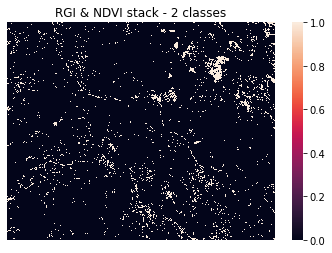

NDVI:
[[0.74812143 0.79632817 0.81230284 ... 0.62253802 0.61466498 0.58783952]
 [0.77982819 0.79063205 0.7885439  ... 0.61677836 0.58548708 0.61703187]
 [0.79738933 0.80591188 0.7731902  ... 0.68928315 0.66305716 0.70941402]
 ...
 [0.75219885 0.75186846 0.78532974 ... 0.58150065 0.40897098 0.66137184]
 [0.77552356 0.76844867 0.76941176 ... 0.66581353 0.49465322 0.6471376 ]
 [0.72339578 0.73302289 0.78872786 ... 0.73055774 0.5357513  0.64802503]]
RGI:
[[0.59857143 0.5503876  0.5467075  ... 0.80617678 0.81323372 0.86325678]
 [0.55987055 0.58333333 0.60305344 ... 0.81953291 0.86068111 0.81118143]
 [0.57860616 0.5704918  0.6407465  ... 0.74141876 0.74498886 0.6930126 ]
 ...
 [0.58168761 0.55704698 0.57168459 ... 0.83161954 0.96551724 0.65229485]
 [0.58632479 0.56120827 0.58934708 ... 0.70524691 0.84301733 0.79607251]
 [0.62075134 0.58803419 0.56845754 ... 0.59036145 0.875      0.63559322]]
Stack:
[[0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 0.]
 ...
 [0. 0. 0. ...

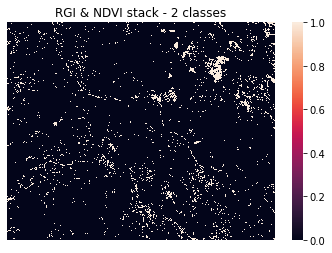

In [ ]:
# Task 3: Stacking one matrix on top of the other

def combinator(np_arr_ndvi_X,np_arr_rgi_X):
  # np_arr_rgi_X = np.copy(rgi_result)
  # np_arr_ndvi_X = np.copy(ndvi_result)
  arr_result = np.copy(np_arr_ndvi_X)
  for i in range(np_arr_ndvi_X.shape[0]):
    for j in range(np_arr_ndvi_X.shape[1]):
      if np_arr_ndvi_X[i][j] == 1 and np_arr_rgi_X[i][j] == 1:
        arr_result[i][j] = 1
      else:
        arr_result[i][j] = 0


  # show image:
  sns.diverging_palette(60, 160, as_cmap=True)
  ax = sns.heatmap(arr_result)
  plt.title("RGI & NDVI stack - 2 classes",fontsize=12)
  plt.xticks([])
  plt.yticks([])
  plt.savefig("NDVI_RGI_binary_2.png", bbox_inches='tight', dpi=100)
  # files.download("NDVI_RGI_binary_2.png")
  plt.show()
  return arr_result

# arr_result = np.copy(np_arr_ndvi_X)
# for i in range(np_arr_ndvi_X.shape[0]):
#   for j in range(np_arr_ndvi_X.shape[1]):
#     if np_arr_ndvi_X[i][j] == 1 and np_arr_rgi_X[i][j] == 1:
#       arr_result[i][j] = 1
#     else:
#       arr_result[i][j] = 0

arr_result = combinator(np_arr_ndvi_X,np_arr_rgi_X)

print('NDVI:')
print(ndvi_result)
print('RGI:')
print(rgi_result)
print('Stack:')
print(arr_result)

# show image:
sns.diverging_palette(60, 160, as_cmap=True)
ax = sns.heatmap(arr_result)
plt.title("RGI & NDVI stack - 2 classes",fontsize=12)
plt.xticks([])
plt.yticks([])
plt.savefig("NDVI_RGI_binary_2.png", bbox_inches='tight', dpi=100)
# files.download("NDVI_RGI_binary_2.png")
plt.show()

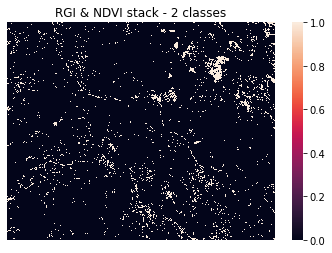

In [ ]:
arr_result = np.copy(np_arr_ndvi_X)
for i in range(np_arr_ndvi_X.shape[0]):
  for j in range(np_arr_ndvi_X.shape[1]):
    if np_arr_ndvi_X[i][j] == 1 and np_arr_rgi_X[i][j] == 1:
      arr_result[i][j] = 1
    else:
      arr_result[i][j] = 0

# show image:
sns.diverging_palette(60, 160, as_cmap=True)
ax = sns.heatmap(arr_result)
plt.title("RGI & NDVI stack - 2 classes",fontsize=12)
plt.xticks([])
plt.yticks([])
plt.savefig("NDVI_RGI_binary_2.png", bbox_inches='tight', dpi=100)
# files.download("NDVI_RGI_binary_2.png")
plt.show()

In [ ]:
def count_pixels(arr_result):
  num_white_pixels = (arr_result == 1).sum()
  print(f'Number of white pixels: {num_white_pixels}')
  print(f'Total number of pixels: {arr_result.shape[0]*arr_result.shape[1]}')
  print(arr_result.shape)
  percentage = num_white_pixels / (arr_result.shape[0] * arr_result.shape[1])
  print(f'Percentage of white pixels: {percentage}')

count_pixels(arr_result)

Number of white pixels: 21340
Total number of pixels: 429030
(630, 681)
Percentage of white pixels: 0.04974011141412023


In [ ]:
def controller(bbox:BBox,date:str):
  config = is_config()
  true_color_image = get_RGB_bands_data(date,bbox,config)
  all_bands_response = get_all_bands_data(date,bbox,config=config)

# get_RGB_bands_data(date:str,bbox:BBox,cofing)
  #bands
  band_b8 = get_band_b8(all_bands_response)
  band_b4 = get_band_b4(all_bands_response)
  band_b3 = get_band_b3(all_bands_response)
  band_b11 = get_band_b11(all_bands_response)

  #NDVI
  ndvi_result = get_ndvi(band_b8,band_b4)
  np_arr_ndvi_X = ndvi_classification(ndvi_result)

  #RGI
  rgi_result = get_rgi(band_b4, band_b3)
  np_arr_rgi_X = rgi_classification(rgi_result)

  # arr_result = combined_classification(np_arr_ndvi_X,np_arr_rgi_X)
  arr_result = combinator(np_arr_ndvi_X,np_arr_rgi_X)

  # arr_result = get_cloud_classifier(arr_result)             => issue recorded with the S2Cloudless algorithm. For more please refer to their github:     https://github.com/sentinel-hub/sentinel2-cloud-detector      
  count_pixels(arr_result)

# controller(bbox,'2017-08-24')

# Here all the methods are called!

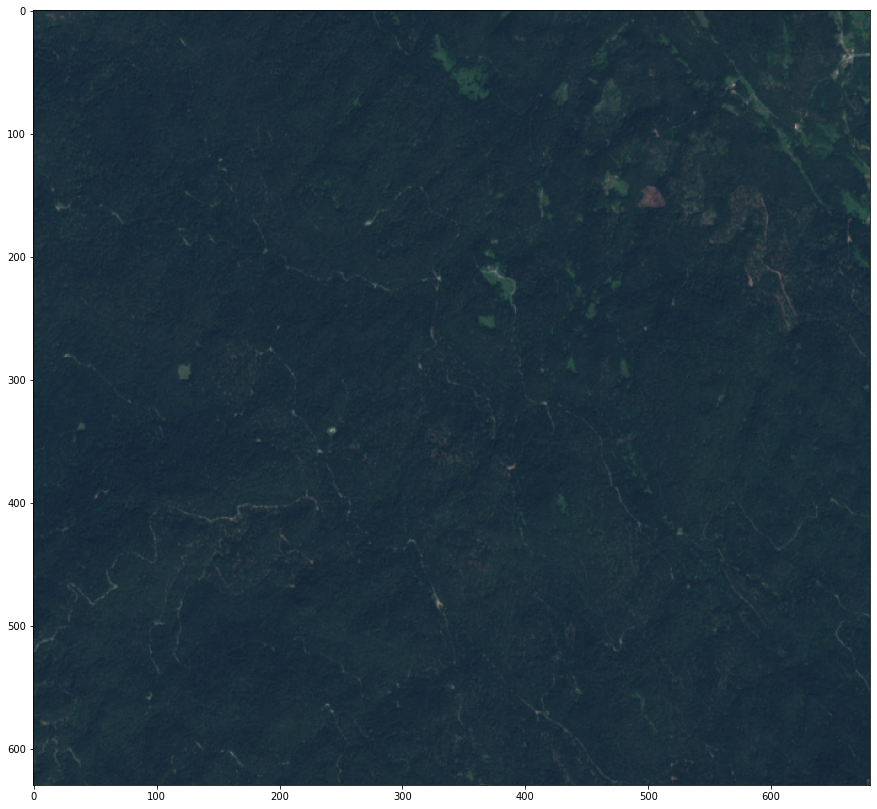

In [ ]:
date = '2016-08-14'
bbox = BBox([14.508835029490873,45.56406848043405,
14.595695686229154,45.62112595663112
], crs=CRS.WGS84)
config = is_config()
true_color_image = get_RGB_bands_data(date,bbox,config)
plot_image(true_color_image)

NORMALISED VEGETATION INDEX
Band 8
Maximum value: 4985
Minimum value: 602
Band 4
Maximum value: 1945
Minimum value: 198
Numerator
Maximum value: 4554
Minimum value: 298
Deominator
Maximum value: 5416
Minimum value: 813
NDVI
Maximum value: 0.8626262626262626
Minimum value: 0.11261261261261261


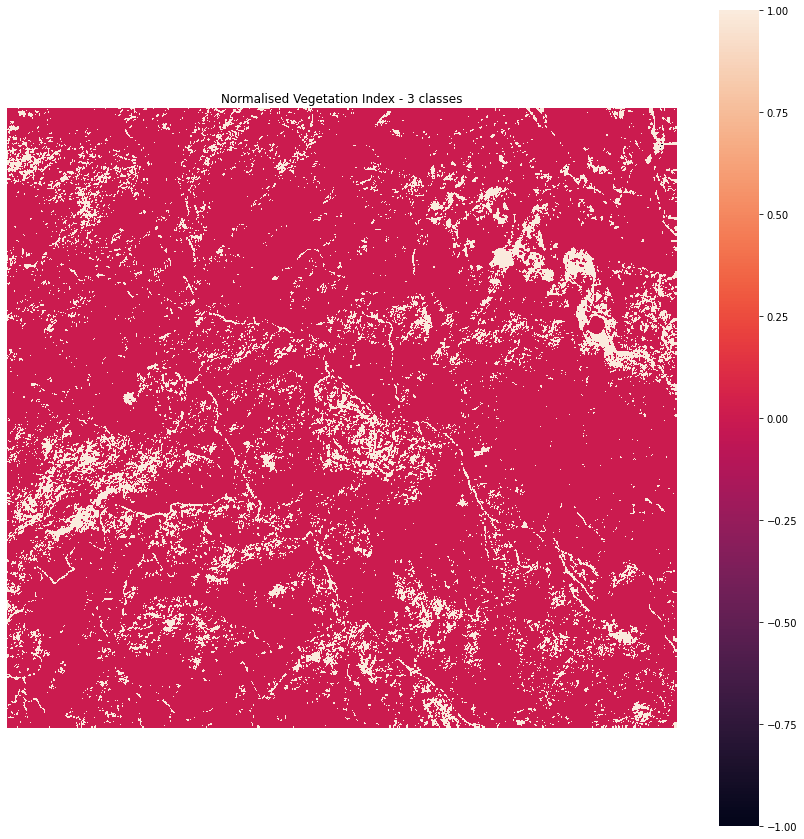

REG GREEN INDEEX
(630, 681)
Maximum value: 1.523281596452328
Minimum value: 0.4367588932806324


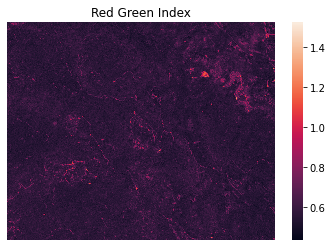

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


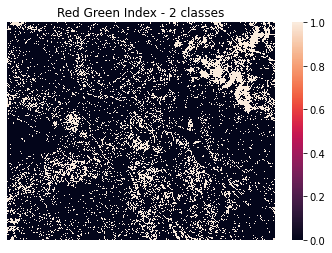

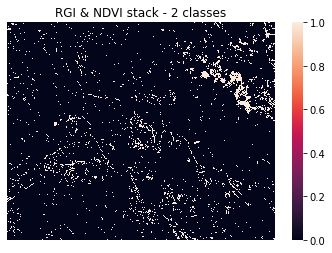

Number of white pixels: 22287
Total number of pixels: 429030
(630, 681)
Percentage of white pixels: 0.05194741626459688


In [ ]:
# region of interes
date = '2016-08-14'
bbox = BBox([14.508835029490873,45.56406848043405,
14.595695686229154,45.62112595663112
], crs=CRS.WGS84)

controller(bbox,date)

-------------------
-------------------
2015
-------------------
-------------------
NORMALISED VEGETATION INDEX
Band 8
Maximum value: 5293
Minimum value: 1505
Band 4
Maximum value: 1757
Minimum value: 262
Numerator
Maximum value: 4877
Minimum value: 1157
Deominator
Maximum value: 5709
Minimum value: 1825
NDVI
Maximum value: 0.8542651953056577
Minimum value: 0.26516102049351736


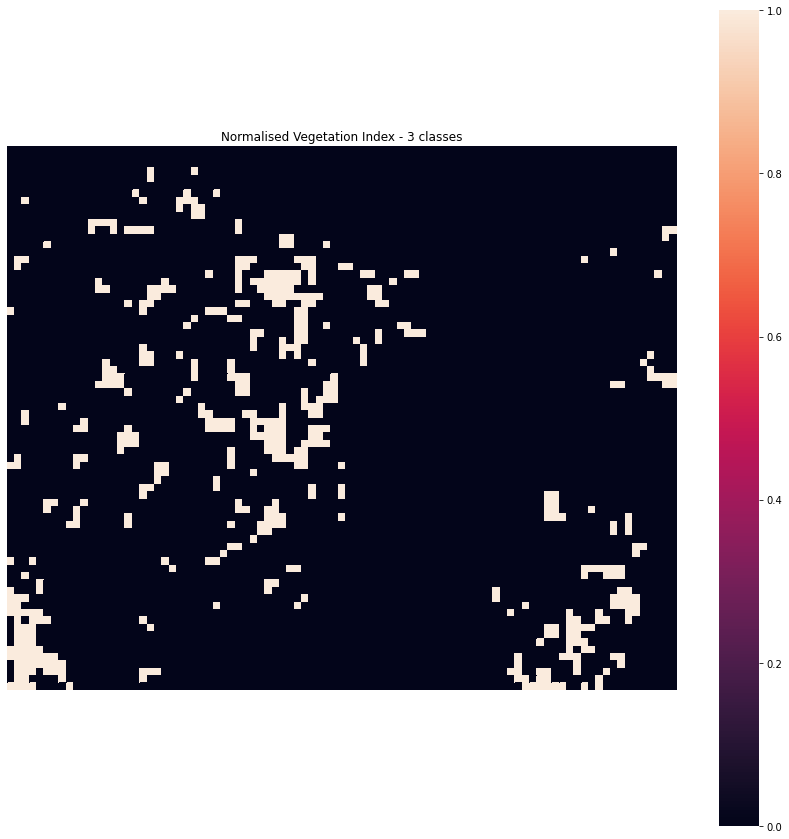

REG GREEN INDEEX
(74, 91)
Maximum value: 1.2731884057971015
Minimum value: 0.45072115384615385


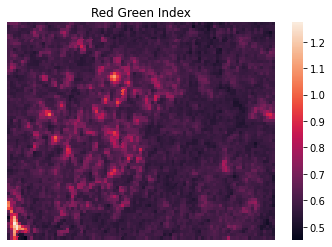

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


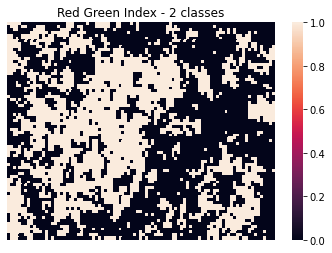

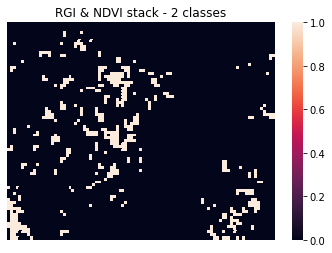

Number of white pixels: 495
Total number of pixels: 6734
(74, 91)
Percentage of white pixels: 0.0735075735075735
-------------------
-------------------
2016
-------------------
-------------------
NORMALISED VEGETATION INDEX
Band 8
Maximum value: 4406
Minimum value: 1166
Band 4
Maximum value: 1666
Minimum value: 222
Numerator
Maximum value: 3956
Minimum value: 944
Deominator
Maximum value: 4856
Minimum value: 1388
NDVI
Maximum value: 0.8481141692150866
Minimum value: 0.2368300503893724


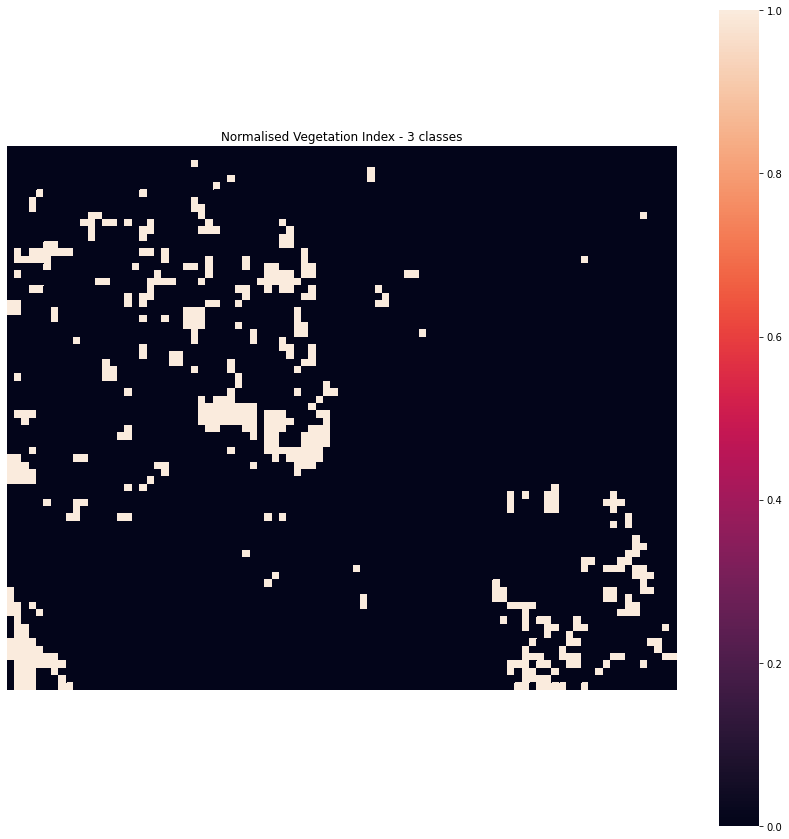

REG GREEN INDEEX
(74, 91)
Maximum value: 1.1934501142421934
Minimum value: 0.4460431654676259


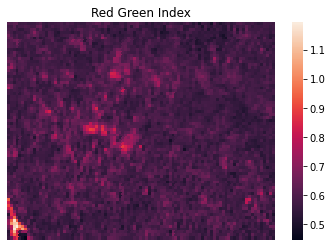

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


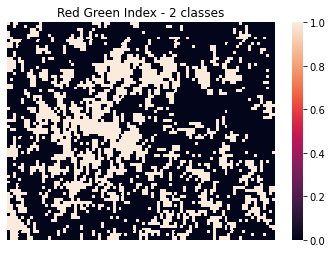

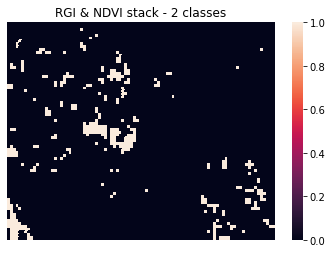

Number of white pixels: 368
Total number of pixels: 6734
(74, 91)
Percentage of white pixels: 0.054648054648054646
-------------------
-------------------
2017
-------------------
-------------------
NORMALISED VEGETATION INDEX
Band 8
Maximum value: 4352
Minimum value: 1237
Band 4
Maximum value: 1679
Minimum value: 253
Numerator
Maximum value: 3826
Minimum value: 948
Deominator
Maximum value: 4878
Minimum value: 1490
NDVI
Maximum value: 0.8450450450450451
Minimum value: 0.2276657060518732


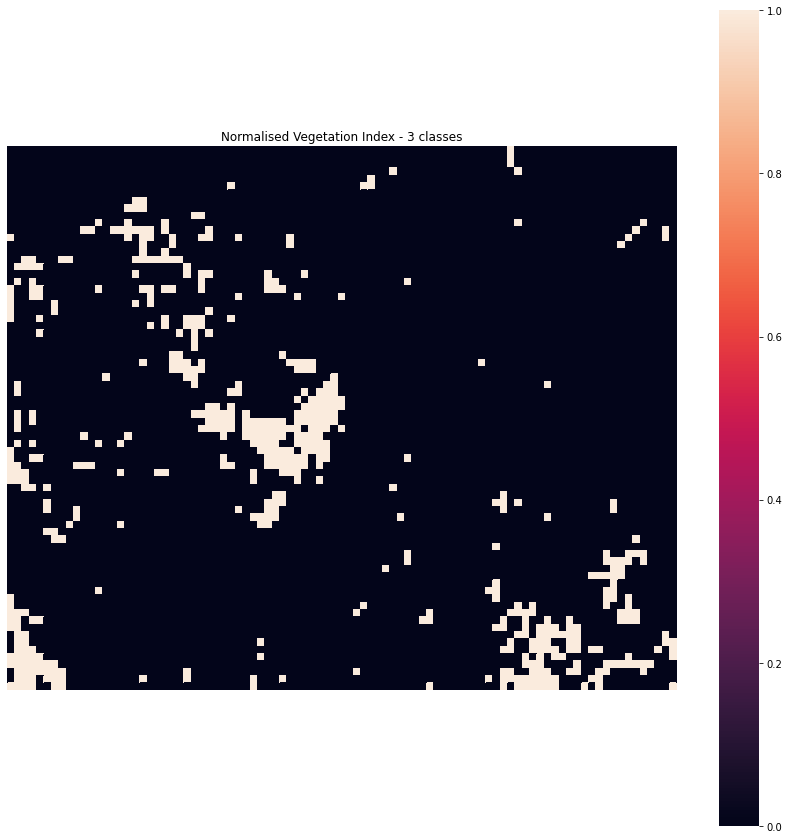

REG GREEN INDEEX
(74, 91)
Maximum value: 1.2293577981651376
Minimum value: 0.4917293233082707


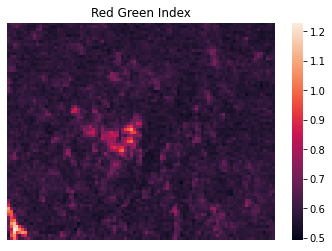

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


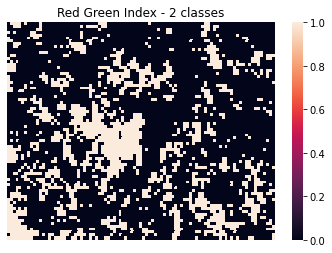

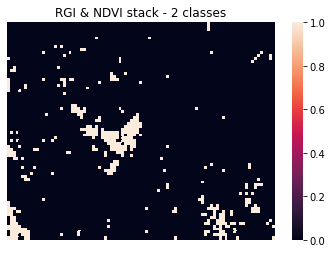

Number of white pixels: 401
Total number of pixels: 6734
(74, 91)
Percentage of white pixels: 0.059548559548559546
-------------------
-------------------
2018
-------------------
-------------------
NORMALISED VEGETATION INDEX
Band 8
Maximum value: 3994
Minimum value: 672
Band 4
Maximum value: 1665
Minimum value: 198
Numerator
Maximum value: 3526
Minimum value: 460
Deominator
Maximum value: 4477
Minimum value: 884
NDVI
Maximum value: 0.8355809128630706
Minimum value: 0.19017509727626458


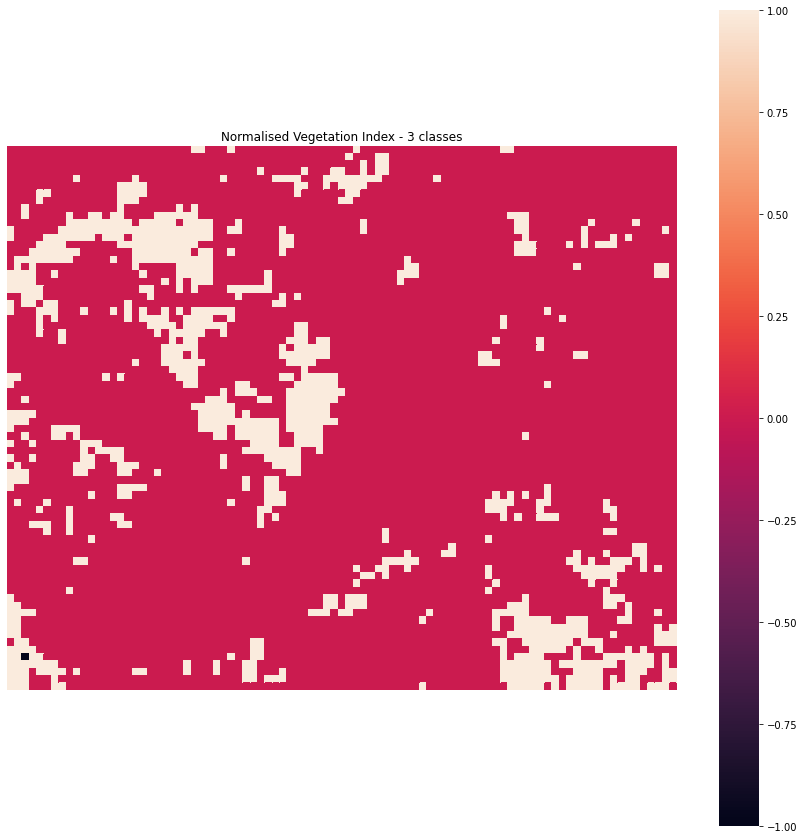

REG GREEN INDEEX
(74, 91)
Maximum value: 1.1280487804878048
Minimum value: 0.46794871794871795


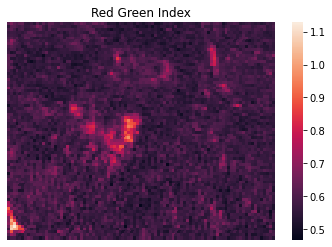

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


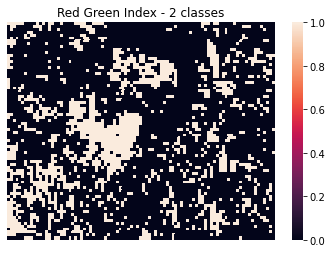

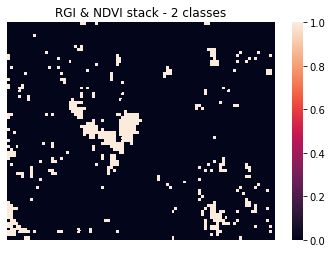

Number of white pixels: 468
Total number of pixels: 6734
(74, 91)
Percentage of white pixels: 0.0694980694980695
-------------------
-------------------
2019
-------------------
-------------------
NORMALISED VEGETATION INDEX
Band 8
Maximum value: 5571
Minimum value: 1685
Band 4
Maximum value: 1891
Minimum value: 265
Numerator
Maximum value: 5144
Minimum value: 1018
Deominator
Maximum value: 5998
Minimum value: 1999
NDVI
Maximum value: 0.8647000983284169
Minimum value: 0.21208333333333335


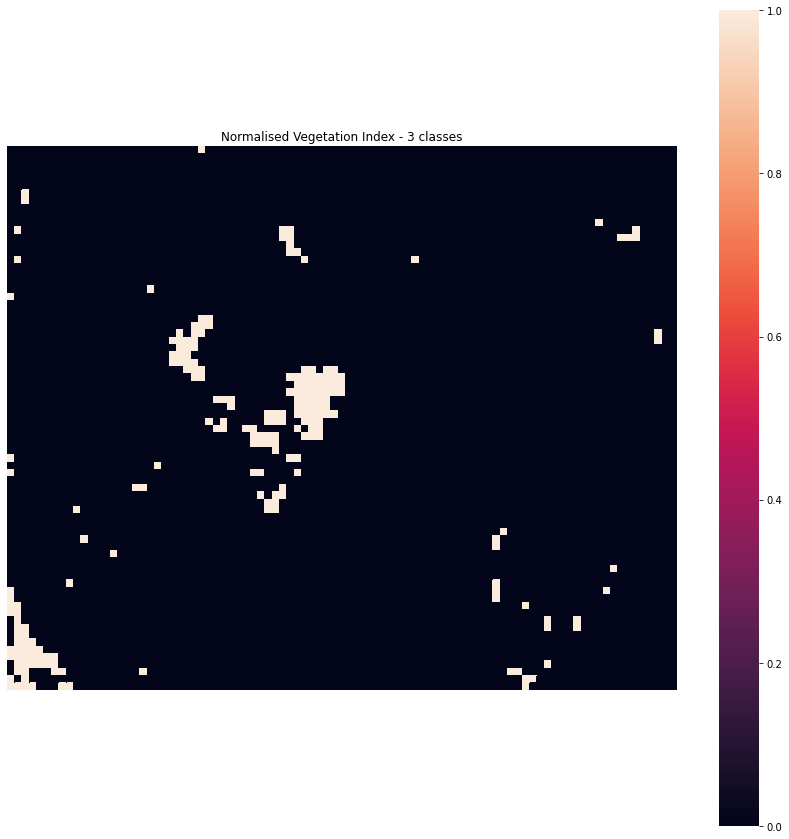

REG GREEN INDEEX
(74, 91)
Maximum value: 1.1923076923076923
Minimum value: 0.4793187347931874


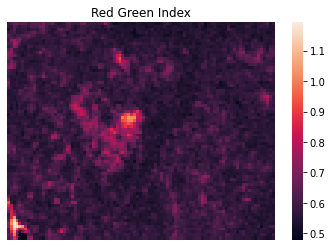

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


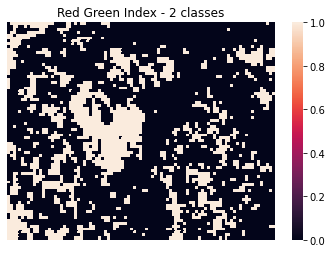

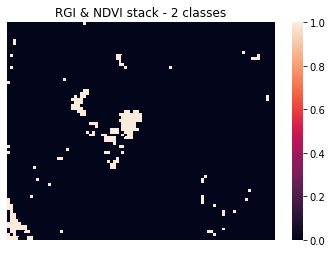

Number of white pixels: 210
Total number of pixels: 6734
(74, 91)
Percentage of white pixels: 0.031185031185031187
-------------------
-------------------
2020
-------------------
-------------------
NORMALISED VEGETATION INDEX
Band 8
Maximum value: 5321
Minimum value: 1519
Band 4
Maximum value: 1801
Minimum value: 259
Numerator
Maximum value: 4886
Minimum value: 1004
Deominator
Maximum value: 5756
Minimum value: 1796
NDVI
Maximum value: 0.8653029718255499
Minimum value: 0.21797655232305688


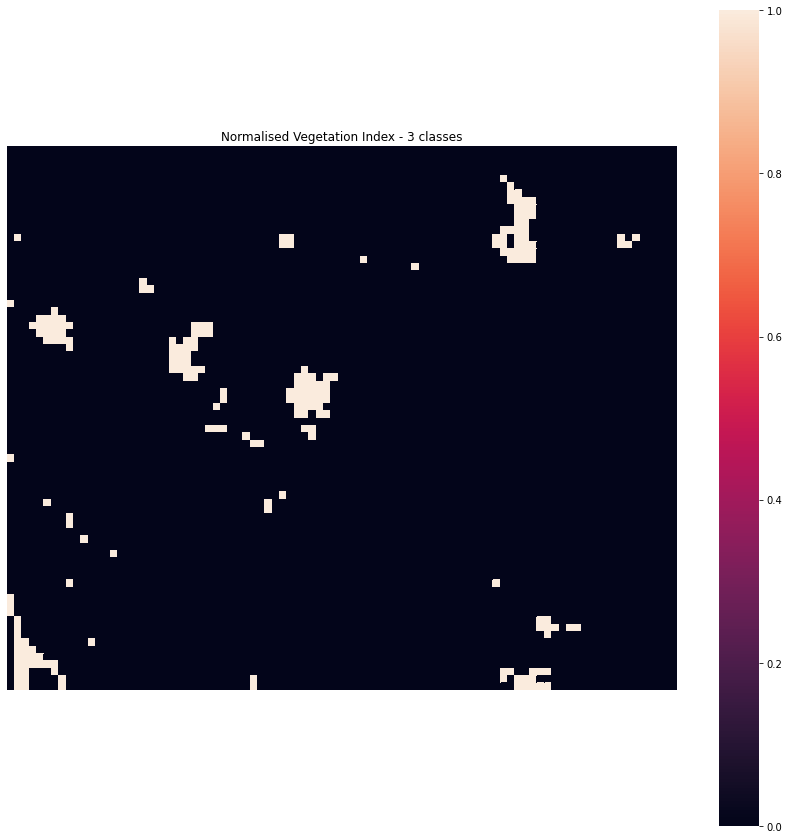

REG GREEN INDEEX
(74, 91)
Maximum value: 1.15033161385409
Minimum value: 0.42857142857142855


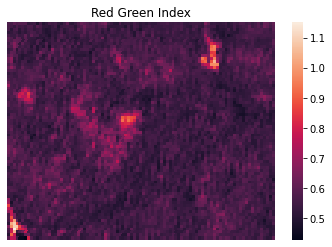

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


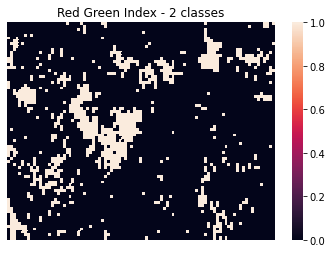

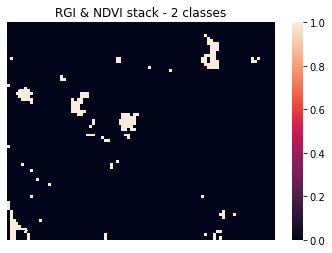

Number of white pixels: 195
Total number of pixels: 6734
(74, 91)
Percentage of white pixels: 0.02895752895752896


In [ ]:
# automating all of it
# region of interes
bbox = BBox([14.55048,45.577028,
             14.562126,45.583712
], crs=CRS.WGS84)

for i in range(2015,2021):
  print('-------------------')
  print('-------------------')
  print(i)
  print('-------------------')
  print('-------------------')
  year_start = str(i)+'-01-01'
  year_end   = str(i)+'-12-31'
  date = (year_start,year_end)
  controller(bbox,date)